In [1]:
import math
import numpy as np
import torch
import pickle

from fastprogress import progress_bar
from functools import partial

from src.nanogpt.model import (
    GPT,
    GPTConfig
)

from src.nanogpt.vocab import Vocabulary

from src.vqvae.model import VQVAE

from src.environment.generic import SyntheticVideoDatasetConfig

from src.utils import compose

In [2]:
gpt: GPT = torch.load("./saved_models/4_1_24/gpt.pt")

with open("./saved_models/4_1_24/config.pkl", "rb") as handle:
    config: GPTConfig = pickle.load(handle)

In [3]:
config

GPTConfig(block_size=331, vocab_size=1042, n_layer=12, n_head=12, n_embd=768, dropout=0.0, bias=False)

In [4]:
vocab = Vocabulary()

vocab.add_token("<sos>")
vocab.add_token("<eos>")
vocab.add_token_range("visual", 1024)
vocab.add_token_range("localization-x", 8)
vocab.add_token_range("localization-y", 8)
localization_tokens = 2
img_tokens = 64

num_frames = 5

In [5]:
device="cuda"
vqvae: VQVAE = torch.load("./saved_models/3_26_24/vqvae.pt")
vqvae.to(device)
gpt.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(1042, 768)
    (wpe): Embedding(331, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=False)
          (c_proj): Linear(in_features=768, out_features=768, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=3072, out_features=768, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=768, out_features=1042, bias=False)
)

In [6]:
# Preprocess dataset
train_x: torch.Tensor = compose(
    lambda x: x / 255.0,
    partial(torch.permute, dims=(0, 1, 4, 2, 3)),
    torch.Tensor.float,
    torch.from_numpy,
    np.load
)("./datasets/4_1_24/frames.npy")

train_y: np.ndarray = compose(
    #torch.Tensor.float,
    #torch.from_numpy,
    np.load
)("./datasets/4_1_24/matrices.npy")

with open("./datasets/4_1_24/config.pkl", "rb") as handle:
    dataset_config: SyntheticVideoDatasetConfig = pickle.load(handle)

# Produce to convert a position in space to a series of tokens
def localization_matrix_to_token_batch(ms: np.ndarray):
    spread: float = dataset_config.trajectory_factory.args[0].spread
    ps = ms[:, :2, -1] / spread * 0.5 + 0.5
    ps = ps.clip(0.0, 1.0)
    x = ps[:, 0]
    y = ps[:, 1]
    x = (x * vocab.get_range_len("localization-x")).astype(np.int32)
    y = (y * vocab.get_range_len("localization-y")).astype(np.int32)
    x = vocab.get_token_in_range("localization-x", x)
    y = vocab.get_token_in_range("localization-y", y)
    return np.stack([x, y], axis=1)

localization_matrix_to_token_pipeline = compose(
    partial(torch.Tensor.to, device=device),
    torch.from_numpy,
    localization_matrix_to_token_batch
)

In [7]:
train_i = torch.from_numpy(np.load("./datasets/4_1_24/indices.npy")).to(device)

In [8]:
@torch.no_grad()
def generate_at_localization(
    idx: int,
    localization_pairs: list[tuple[int, int]]
) -> np.ndarray:
    gpt.eval()
    indices = train_i[idx:idx+1].to(device)
    indices = indices.repeat(len(localization_pairs), 1, 1)
    start_token = torch.tensor([[ vocab.get_token("<sos>") ]], device=device).repeat(indices.size(0), 1)
    tokens = [start_token]
    
    # add context images + localization
    for i in range(4):
        tokens.append(localization_matrix_to_token_pipeline(train_y[idx:idx+1, i]).repeat(len(localization_pairs), 1))
        tokens.append(vocab.get_token_in_range("visual", indices[:, i, :]))
    
    # add requested localization
    tokens.append(torch.tensor([[ 
        vocab.get_token_in_range("localization-x", localization_x),
        vocab.get_token_in_range("localization-y", localization_y) 
    ] for (localization_x, localization_y) in localization_pairs], device=device))
    
    tokens = torch.cat(tokens, dim=1)

    # generate
    generated = gpt.generate(tokens, img_tokens, temperature=0.5, top_k=None)
    generated = generated[:, -64:]
    generated = generated - vocab.get_range_start("visual")
    generated = torch.maximum(generated, torch.zeros_like(generated))
    generated = torch.minimum(generated, torch.ones_like(generated) * (vocab.get_range_len("visual") - 1))
    
    # decode
    z_quantized = []
    for i in range(generated.size(0)):
        embeddings: torch.Tensor = vqvae.vq.e_i_ts[:, generated[i]]
        embeddings = embeddings.reshape(-1, 8, 8)
        z_quantized.append(embeddings)
    z_quantized = torch.stack(z_quantized)
    imgs: torch.Tensor = vqvae.decoder(z_quantized)
    
    # format as image
    imgs: np.ndarray = imgs.cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs.clip(0.0, 1.0) * 255.0).astype(np.uint8)
    return imgs


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
torch.cuda.empty_cache()

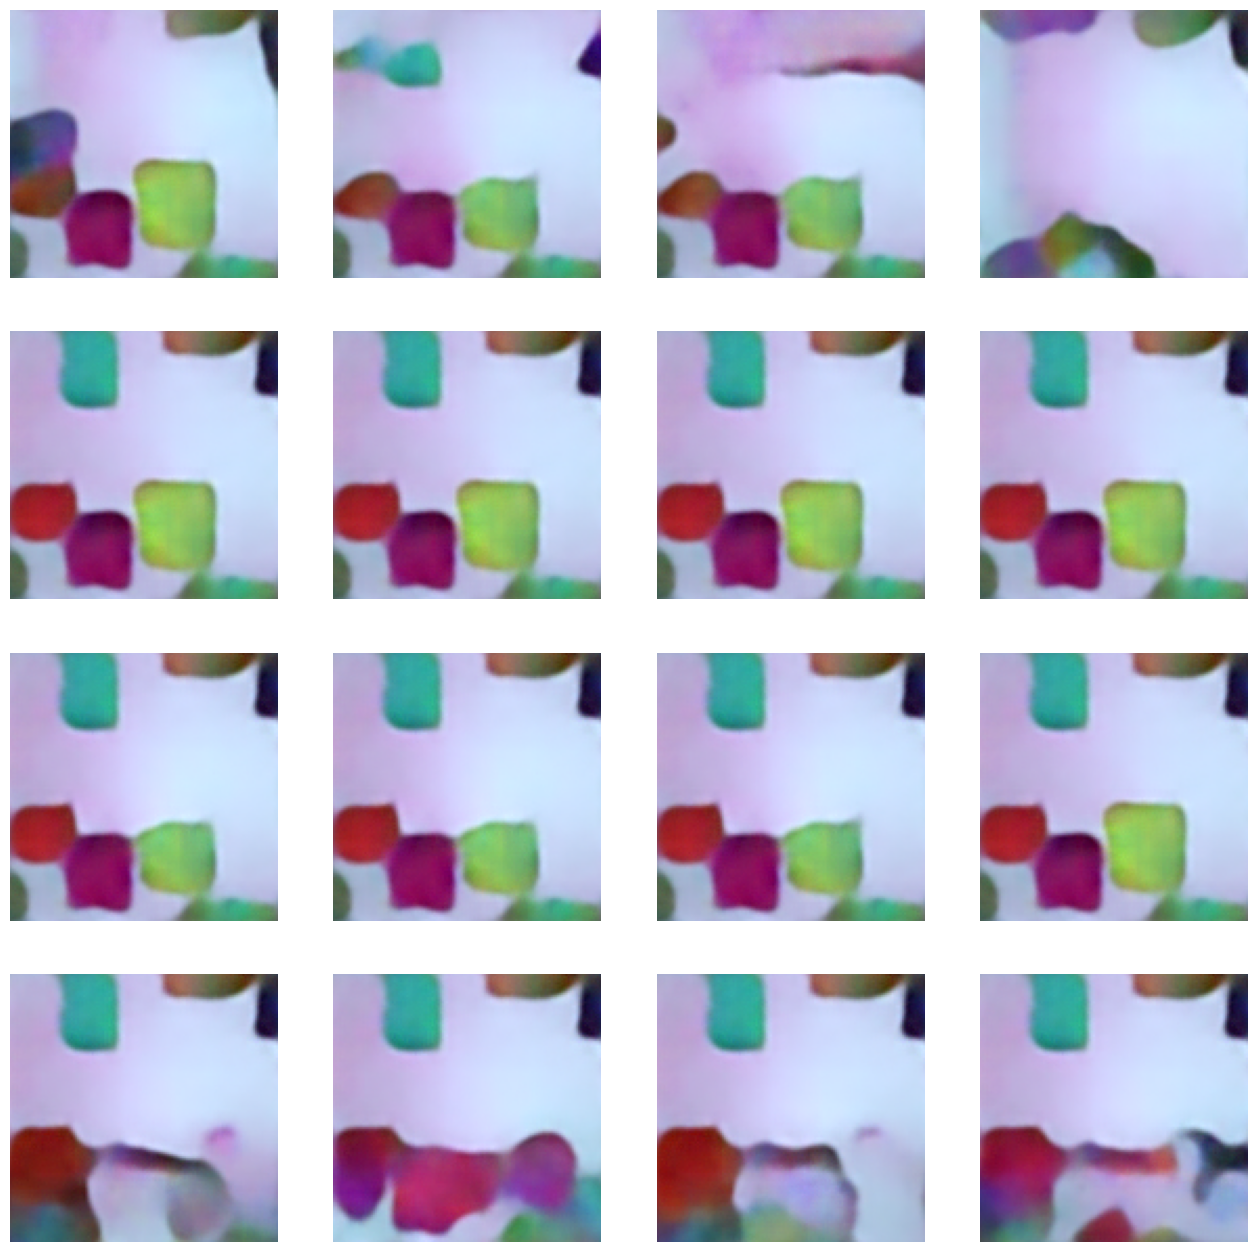

In [18]:
localization_pairs = [(i*2, j*2) for i in range(4) for j in range(4)]
imgs = generate_at_localization(15, localization_pairs)

fig, ax = plt.subplots(nrows=4, ncols=4)
fig.set_size_inches(16, 16)
for i in range(4):
    for j in range(4):
        ax[i, j].axis('off')
        ax[i, j].imshow(imgs[j + i * 4])